In [ ]:
#konlpy 설치
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 41.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
import tqdm
import collections
from wordcloud import WordCloud
from PIL import Image#이미지 데이터 불러오고 처리하는 라이브러리
import matplotlib.pyplot as plt
from collections import Counter

## 데이터 불러오기

In [ ]:
data=pd.read_csv("final.tsv")#, delimiter='\t'
data.head()

,title,comments
0,전통한옥 단독주택 독체. 바동,좋았습니다
1,전통한옥 단독주택 독체. 바동,이런 부분들만 제외하면 그래도 괜찮았습니다
2,전통한옥 단독주택 독체. 바동,1박 2일이었지만 좋은 기억 남기고 갑니다☺️ 보통 한옥 숙박이 평지에 많이 있는데...
3,전통한옥 단독주택 독체. 바동,고즈넉한 분위기의 한옥에서 잘 쉬다 왔습니다
4,전통한옥 단독주택 독체. 바동,숙소 컨디션이 너무 좋았어요 2박 하는 동안 하루는 비가 왔는데 한옥에서보니 그것도...


In [ ]:
data.shape

(36364, 2)

# 전처리

In [ ]:
#한국어만 남기기
data["korean_only"] = [re.sub('[^가-힣\s]+', ' ', s) for s in data["comments"]]
data["korean_only"]=data["korean_only"].str.replace('  ',' ')
data["korean_only"]=data["korean_only"].str.strip()
#참고사항: 0-9를 안넣어서 n마리->마리가 되었다.

In [ ]:
# 길이가 1인 셀을 지웠다.
data2= data[data["korean_only"].map(len)>1]

#korean_only의 최소값 알아보기
np.min(data2["korean_only"].map(len))

2

In [ ]:
data2[data2["korean_only"].map(len)==2].head()

,title,comments,korean_only
787,"하조대3분거리, 숲속같은 2000평 단독 풀빌라를 오롯이 한팀만!!",원래,원래
2071,• Saudade 사우다지 🌱,굳굳,굳굳
3507,♥️공스테이 ♥️수영장 + 캠핑 ⛺파노라마 View 🏖 루프탑 영화관 🎁바베큐장비무...,깔끔,깔끔
4072,애월 노천탕 소길리 애월풀빌라신축,굿굿,굿굿
4166,[🏙 15층 / Ocean view]🏖 #OKI HOUSE SEASON.2 _오키네,최강,최강


In [ ]:
data2.shape

(35756, 3)

## 형태소 분석기 및 불용어 처리 (StopWord)

In [ ]:
#토큰화 작업
okt=Okt()
data2['okt_tokens']=data2['korean_only'].apply(lambda my_list: okt.morphs(my_list, stem=True))

<ipython-input-35-2d84f74efb01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['okt_tokens']=data2['korean_only'].apply(lambda my_list: okt.morphs(my_list, stem=True))


In [ ]:
#인덱스 재설정- 안하면 뒤에서 에러남
data2=data2.reset_index(drop=True)

In [ ]:
#불용어 처리
stopwords=['은','는','이','가','이다','하다','와','과','으로','에게','에','게','도']

data2["words"]=np.nan
my_len=data2.shape[0]
for i in tqdm.tqdm(range(my_len)):
   #불용어 제거
   data2["words"][i]=([word for word in data2['okt_tokens'][i] if not word in stopwords])

#불용어가 들어있는 토큰은 지운다
data2.drop(["okt_tokens"],axis=1, inplace=True)

  0%|          | 0/41700 [00:00<?, ?it/s]<ipython-input-37-2a0f35a7c38d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["words"][i]=([word for word in data2['okt_tokens'][i] if not word in stopwords])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
100%|██████████| 41700/41700 [00:00<00:00, 51183.62it/s]


## EDA

이모티콘 등을 제외한 한글 댓글의 길이(`korean_only`)에 대한 정보는 아래와 같다.

In [ ]:
temp_df=pd.DataFrame(data2["korean_only"])
temp_df["korean_len"]=data2["korean_only"].map(len)
pd.DataFrame(temp_df["korean_len"].describe().round(0)).T

,count,mean,std,min,25%,50%,75%,max
korean_len,41700.0,74.0,100.0,2.0,16.0,39.0,93.0,1629.0


최빈어를 알아보자

In [ ]:
tokens_temp=sum(list(data2["words"]), [])

print(collections.Counter(tokens_temp).most_common(20))

[('좋다', 31262), ('너무', 20060), ('있다', 17929), ('숙소', 10578), ('자다', 10296), ('가다', 10041), ('친절하다', 9481), ('님', 9424), ('오다', 9297), ('들', 8444), ('사장', 7926), ('을', 7910), ('또', 6674), ('에서', 6454), ('다', 6434), ('깨끗하다', 6296), ('보다', 5853), ('없다', 5694), ('같다', 5665), ('정말', 5637)]


In [ ]:
#워드 클라우드를 위해 명사만 남기기
wc_df=data2['korean_only'].apply(lambda my_list: okt.nouns(my_list))
wc_temp=sum(wc_df, [])

In [ ]:
count_dic={}

for i in wc_temp:
    if len(i)>1:
        if i in count_dic:
            count_dic[i]+=1
        else:
            count_dic[i]=1
#count_dic

워드 클라우드를 그리면 다음과 같다

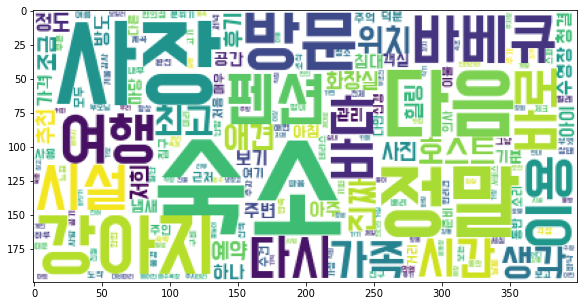

In [ ]:
#워드 클라우드 만들기
wc=WordCloud(font_path="BMDOHYEON_ttf.ttf",
             background_color='white')
cloud=wc.generate_from_frequencies(count_dic)

plt.figure(figsize=(10,5))
plt.imshow(cloud)
#워드 클라우드 저장
plt.savefig("wc.png")

## '애견동반' 관련 단어 유무 컬럼 만들기

In [ ]:
dog_list=['강아지','개','반려', '반려동물','반려견','소형견','중형견','대형견','견', '애견'
            '댕댕', '멍멍', '애완', '얘완','에완', '애완', '얘완','에완', '애완견','똥강아지','댕댕이도'
            '갱얼쥐', '갱쥐','강쥐', '마리', '배변패드' ]


data2["dog_info"]=0
my_len=data2.shape[0]
for i in tqdm.tqdm(range(my_len)):
    for word in data2['words'][i]:
        if word in dog_list:
            data2["dog_info"][i]=1



  0%|          | 0/41700 [00:00<?, ?it/s]<ipython-input-45-e92bbffe03b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["dog_info"][i]=1
100%|██████████| 41700/41700 [00:02<00:00, 18578.85it/s]


In [ ]:
#총 데이터 수는
print('총 데이터 수는',data2["dog_info"].sum())


총 데이터 수는 5044


In [ ]:
#data2.to_csv("중간점검.csv",index=False, encoding="utf-8-sig")

In [ ]:
##포함되지 않은 데이터 알아보기
#except_data=data2[data2["dog_info"]==0]
#except_data.to_csv("except_data.csv",index=False, encoding="utf-8-sig")

In [ ]:
#최종 데이터 셋
final_dog=data2[data2["dog_info"]==1]
final_dog.drop(columns=["comments","dog_info",],inplace=True)
final_dog.head()

final_dog.to_csv("final_dog.csv",index=False, encoding="utf-8-sig")

#피클파일로 저장
final_dog.to_pickle('final_dog.pickle')#,index=False, encoding="utf-8-sig"

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 워드 클라우드2

애견 동반 유무에 따라서 워드 클라우드가 어떻게 달라지는지 보는 것을 목적

In [ ]:
dog_yes=data2[data2["dog_info"]==1]
dog_no=data2[data2["dog_info"]==0]

#워드 클라우드를 위해 명사만 남기기
dog_yes=dog_yes['korean_only'].apply(lambda my_list: okt.nouns(my_list))
dog_yes=sum(dog_yes, [])

dog_no=dog_no['korean_only'].apply(lambda my_list: okt.nouns(my_list))
dog_no=sum(dog_no, [])

In [ ]:
dic_yes={}

for i in dog_yes:
    if len(i)>1:
        if i in dic_yes:
            dic_yes[i]+=1
        else:
            dic_yes[i]=1

dic_no={}

for i in dog_no:
    if len(i)>1:
        if i in dic_no:
            dic_no[i]+=1
        else:
            dic_no[i]=1


애견동반 이용자들의 워드 클라우드는 다음과 같다

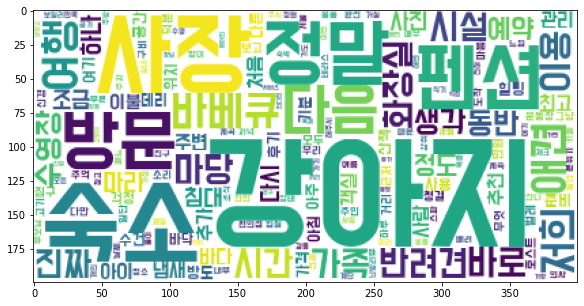

In [ ]:
#워드 클라우드 만들기
cloud=wc.generate_from_frequencies(dic_yes)

plt.figure(figsize=(10,5))
plt.imshow(cloud)
#워드 클라우드 저장
plt.savefig("wc_user_with_dog.png")

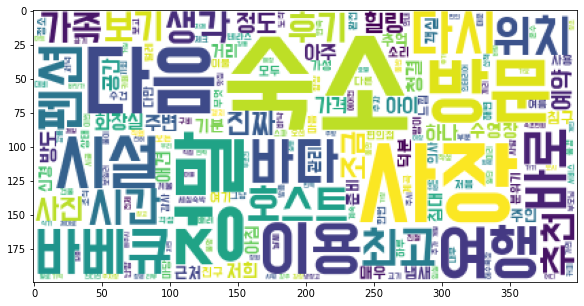

In [ ]:
#워드 클라우드 만들기
wc=WordCloud(font_path="BMDOHYEON_ttf.ttf",
             background_color='white')
cloud=wc.generate_from_frequencies(dic_no)

plt.figure(figsize=(10,5))
plt.imshow(cloud)
#워드 클라우드 저장
plt.savefig("wc_user_with_no_dog.png")